# Tutorial: Automated Machine Learning
This is the code for the paper entitled "**[IoT Data Analytics in Dynamic Environments: From An Automated Machine Learning Perspective](https://arxiv.org/abs/2209.08018)**" published in *Engineering Applications of Artificial Intelligence* (Elsevier's Journal, IF:7.8).<br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)<br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "IoT Data Analytics in Dynamic Environments: From An Automated Machine Learning Perspective", *Engineering Applications of Artificial Intelligence*, vol. 116, pp. 1-33, 2022, doi: https://doi.org/10.1016/j.engappai.2022.105366.

# Code Part 2: Automated Online Learning (Dynamic Data Stream Analytics)
Online learning: Online learning techniques are able to train models using continuously incoming online data streams in dynamic environments. By learning a single data sample at a time, online learning models can reduce memory requirements for data storage and learn new data patterns. Additionally, online learning models can often achieve real-time processing and address concept drift issues. Thus, when applied to dynamic data streams or when inadequate data is available, online learning is often more effective than batch learning.

## Dataset 1: CICIDS2017
A subset of the network traffic data randomly sampled from the [CICIDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html).  

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import time

In [2]:
import warnings 
warnings.filterwarnings('ignore')

## Read the sampled CICIDS2017 dataset

In [3]:
df = pd.read_csv("Data/cic_0.01km.csv")

In [4]:
df

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Label
0,50833,0,0,0.0000,0,0,5.083300e+04,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0000,0,0,4.900000e+01,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0000,6,6,3.060000e+02,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0000,124,124,6.304100e+04,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0000,59,59,4.768200e+04,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,45,0,0,0.0000,0,0,4.500000e+01,45,0,32,32,22222.222220,22222.222220,0,1,1,349,307,32,0
28299,114309573,511,427,31.9375,746,0,3.941709e+06,94,165,332,424,0.139971,0.122474,0,0,0,8192,343,20,0
28300,48850,80,40,40.0000,72,72,1.628333e+04,1,48,64,64,40.941658,40.941658,40,0,1,-1,-1,32,0
28301,260,66,33,33.0000,97,97,8.666667e+01,48,48,40,40,7692.307692,7692.307692,33,0,1,-1,-1,20,0


# 1. Automated Data Pre-Processing

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [5]:
# Define the automated data encoding function
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

In [6]:
df=Auto_Encoding(df)

## Automated Imputation
Detect and impute missing values to improve data quality

In [7]:
# Define the automated data imputation function
def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df

In [8]:
df=Auto_Imputation(df)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [9]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index
    
    # check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

In [10]:
df=Auto_Normalization(df)

Statistics=0.076, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


# 2. Automated Feature Engineering
Feature selection method 1: **Information Gain (IG)**, used to remove irrelevant features to improve model efficiency  
Feature selection method 2: **Pearson Correlation**, used to remove redundant features to improve model efficiency and accuracy  

In [11]:
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    features = data.drop(['Label'],axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values
    
    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
#     print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [12]:
# Remove redundant features
def Feature_Redundancy_Pearson(data):
    correlation_threshold=0.90 # Only remove features with the redundancy>90%. It can be changed
    features = data.drop(['Label'],axis=1)
    corr_matrix = features.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
#     print(record_collinear)
    return to_drop

In [13]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns = drop1)
    
    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns = drop2)
    
    return dfh2

In [14]:
dfh2 = Auto_Feature_Engineering(df)
dfh2

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Packets/s,Init_Win_bytes_forward,Init_Win_bytes_backward,Label
0,4.236419e-04,0.000000,0.000000,0.000000,0.000000,4.707129e-04,4.707129e-04,0.000000e+00,0.000150,1.311484e-05,0.004883,0.002350,0
1,4.416669e-07,0.000000,0.000000,0.000000,0.000000,4.907407e-07,4.907407e-07,4.083333e-07,0.000299,0.000000e+00,0.004242,0.000000,0
2,2.583334e-06,0.000008,0.000242,0.001556,0.000516,2.870370e-06,2.870370e-06,0.000000e+00,0.000094,2.178649e-03,0.000015,0.000015,0
3,5.253752e-04,0.000090,0.002619,0.016856,0.010660,5.837500e-04,5.837500e-04,0.000000e+00,0.000150,1.057513e-05,0.000000,0.000000,0
4,3.973835e-04,0.000060,0.001732,0.011151,0.005072,4.415370e-04,4.415370e-04,0.000000e+00,0.000150,1.398152e-05,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,4.083335e-07,0.000000,0.000000,0.000000,0.000000,4.537037e-07,4.537037e-07,0.000000e+00,0.000150,1.481481e-02,0.005341,0.004700,0
28299,9.525802e-01,0.000710,0.017204,0.008282,0.064133,3.649735e-02,9.074074e-07,1.375000e-06,0.001554,8.164962e-08,0.125015,0.005249,0
28300,4.071168e-04,0.000111,0.001612,0.010373,0.006190,1.508086e-04,4.629629e-08,4.000000e-07,0.000299,2.729444e-05,0.000000,0.000000,0
28301,2.200001e-06,0.000092,0.001330,0.008558,0.008339,8.395061e-07,4.814815e-07,4.000000e-07,0.000187,5.128205e-03,0.000000,0.000000,0


## Train-test split
Split the dataset into the training and the test set   

Here we used the 1%/99% split, because for online learning, the initial available data would only be a small percentage, and the incoming data streams will be continously learned by the data analytics models. It can be changed based on specific tasks

In [15]:
X = dfh2.drop(['Label'],axis=1)
y = dfh2['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.01, test_size = 0.99, shuffle=False,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [16]:
pd.Series(y_train).value_counts()

0    180
1    103
Name: Label, dtype: int64

In [17]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train, y_train):
    number0 = pd.Series(y_train).value_counts().iloc[0]
    number1 = pd.Series(y_train).value_counts().iloc[1]
    
    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1
    
    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%)) 
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    return X_train, y_train

In [18]:
X_train, y_train = Auto_Balancing(X_train, y_train)

In [19]:
pd.Series(y_train).value_counts()

1    180
0    180
Name: Label, dtype: int64

# 3. Model Learning

Four state-of-the-art online learners: 
* Hoeffding Tree (HT)
* Leveraging Bagging (LB)
* Adaptive Random Forest (ARF) 
* Streaming Random Patches (SRP)


An offline learner for comparison:
* LightGBM


## Static Model learning: LightGBM (for Comparison)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     22482
           1       0.91      0.21      0.34      5538

    accuracy                           0.84     28020
   macro avg       0.87      0.60      0.62     28020
weighted avg       0.85      0.84      0.80     28020

Accuracy: 83.958%
Precision: 90.902%
Recall: 20.928%
F1-score: 34.022999999999996%


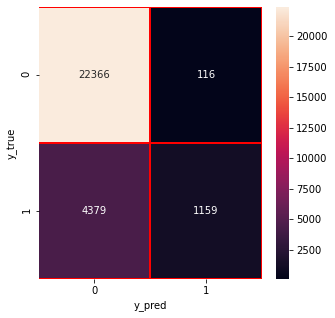

Wall time: 292 ms


In [20]:
%%time
# LightGBM algorithm
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+str(round(accuracy_score(y_test, y_pred),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test, y_pred),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test, y_pred),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test, y_pred),5)*100)+"%")

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

The accuracy of the static LightGBM model is very low (83.958%), due to the occurance of concept drift (data distribution changes). Therefore, online learning methods that can adapt to concept drift issues should be developed for dynamic data stream analytics.

## Online Learning

In [62]:
# Import the online learning metrics and algorithms from the River library
import river
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, EDDM, ADWIN

In [32]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),5)*100)+"%")
    return t, m

In [33]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 93.173%
Precision: 80.083%
Recall: 87.125%
F1-score: 83.456%
Wall time: 5.06 s


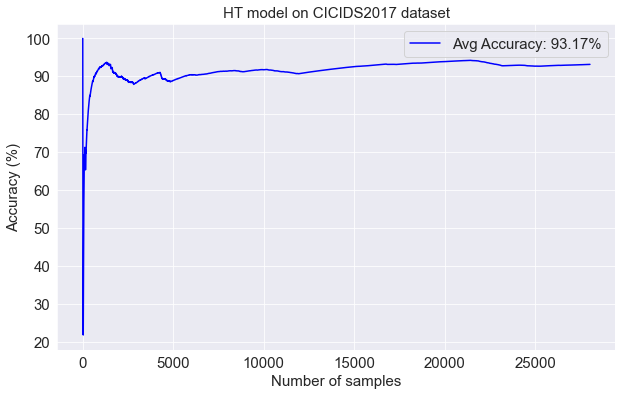

In [34]:
%%time
# Use the Hoeffding Tree (HT) model 
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier() # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.665%
Precision: 97.341%
Recall: 95.865%
F1-score: 96.598%
Wall time: 56.5 s


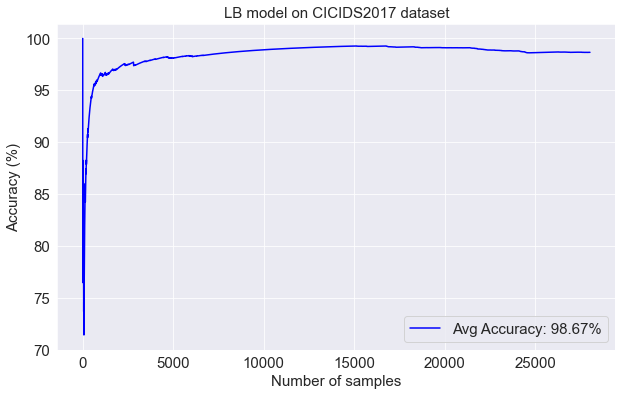

In [35]:
%%time
# Use the Leveraging Bagging (LB) model 
name2 = "LB model"
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.033%
Precision: 98.526%
Recall: 96.551%
F1-score: 97.528%
Wall time: 19.8 s


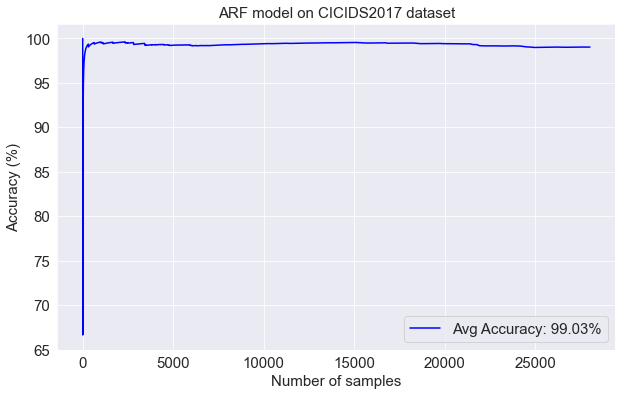

In [36]:
%%time
# Use the Adaptive Random Forest (ARF) model
name3 = "ARF model"
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.036%
Precision: 98.18900000000001%
Recall: 96.91199999999999%
F1-score: 97.54599999999999%
Wall time: 49.6 s


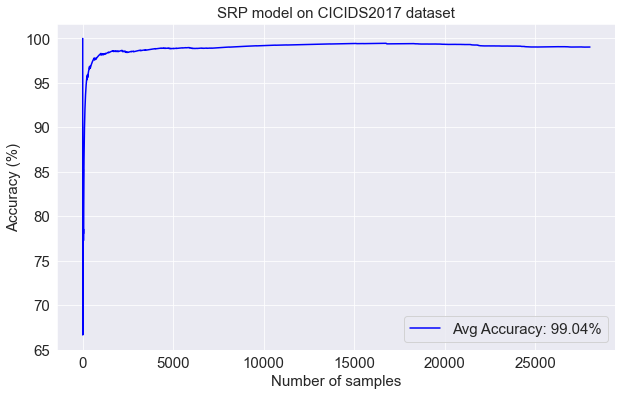

In [37]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP model"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

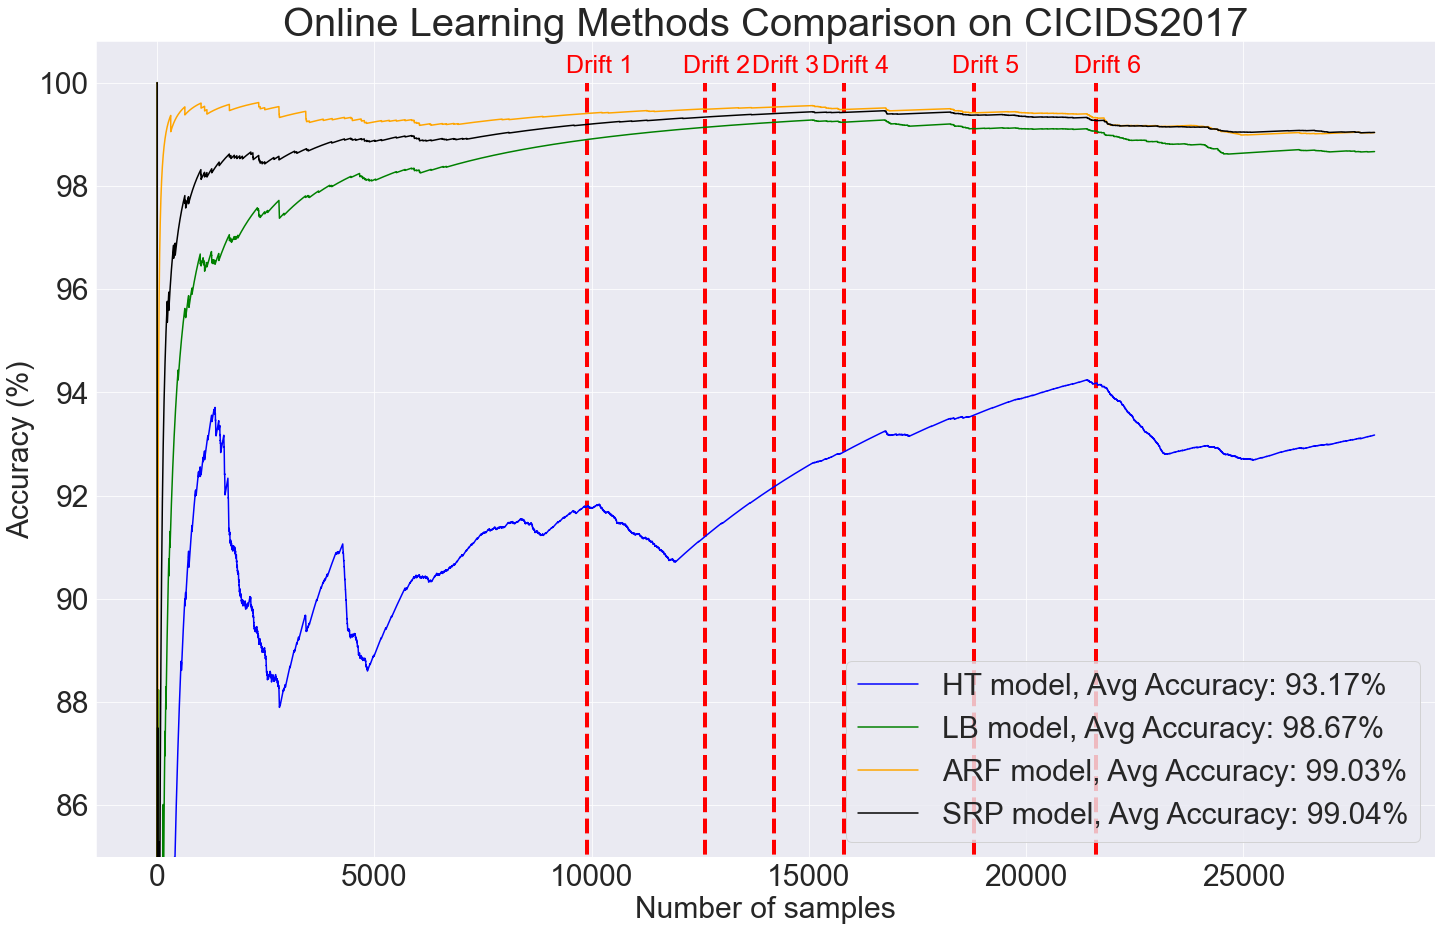

In [42]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))

# Draw the drift points/time
dr = [0,9900,12600, 14200,15800,18800,21600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(85, 100.8)
plt.title('Online Learning Methods Comparison on CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

## Automated Online Learning Model Selection

Select the best-performing model among four state-of-the-art online learning models (HT, LB, ARF, and SRP) by evaluating their learning performance

In [46]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    ypb = [] # record all the predicted labels of the test set for the best performing model
    acc_b = 0 # The best accuracy score
    mb = [] # record the real-time accuracy of the best performing model
    
    for model in model_list:
        # Learn the training set
        for xi1, yi1 in stream.iter_pandas(X_train, y_train):
            model.learn_one(xi1,yi1) 

        # Predict the test set
        for xi, yi in stream.iter_pandas(X_test, y_test):
            y_pred= model.predict_one(xi)  # Predict the test sample
            model.learn_one(xi,yi) # Learn the test sample
            metric = metric.update(yi, y_pred) # Update the real-time accuracy
            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred)
            i = i+1
#         print(accuracy_score(yt,yp))
        if accuracy_score(yt,yp)>acc_b:
            acc_b = accuracy_score(yt,yp)
            mb = m
            ypb = yp
            model_b = model
            
    print(model_b)    
    print("Accuracy: "+str(round(accuracy_score(yt,ypb),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,ypb),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,ypb),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,ypb),5)*100)+"%")
    return t, mb

In [44]:
model1 = tree.HoeffdingTreeClassifier() 
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3)
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3)
model4 = ensemble.SRPClassifier(n_models = 3)
model_list = [model1, model2, model3, model4]
t, mb = adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test) # Learn the model on the dataset

SRPClassifier(HoeffdingTreeClassifier)
Accuracy: 99.036%
Precision: 98.189%
Recall: 96.912%
F1-score: 97.546%


SRP with the highest accuracy is selected as the best/most suitable online learner

# 4. Hyperparameter Optimization
Optimize the best performing online learning model (SRP) by tuning its hyperparameters

In [68]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    params = {
        'n_models': int(params['n_models']), 
        'subspace_size': abs(float(params['subspace_size'])),
    }
    clf = ensemble.SRPClassifier( **params)
    
    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)
    
    return {'loss':-m[-1], 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_models': hp.quniform('n_models', 2, 10, 1),
    "subspace_size":hp.uniform('subspace_size', 0.3, 1),
}

# Detect the optimal hyperparameter values
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("SRP: Hyperopt estimated optimum {}".format(best))

Accuracy: 99.247%                                                                                                      
Precision: 99.13300000000001%                                                                                          
Recall: 97.039%                                                                                                        
F1-score: 98.075%                                                                                                      
Accuracy: 99.25399999999999%                                                                                           
Precision: 99.279%                                                                                                     
Recall: 96.93%                                                                                                         
F1-score: 98.09%                                                                                                       
Accuracy: 99.029%                       

After hyperparameter optimization, the accuracy of SRP has been improved from 99.036% to 99.254%